# 🧠 D&D Monster Analytics: Fase 3 - Training, Valutazione & Analisi Profonda

**Obiettivo:** In questa fase addestriamo tre diversi algoritmi per predire il Challenge Rating (CR). Successivamente, eseguiamo una "autopsia" matematica sul modello Random Forest per capire non solo *quanto* è preciso, ma *come* ragiona.

### 📋 Struttura dell'Analisi:
1.  **Model Selection:** Confronto competitivo tra Regressione Lineare, Random Forest e Gradient Boosting.
2.  **Performance Check:** Chi ha l'errore più basso?
3.  **Random Forest Deep Dive:** 5 Grafici avanzati per analizzare la stabilità e la logica interna del modello.
4.  **Error Analysis:** Studio dei residui per confermare l'assenza di bias.

---


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Sklearn Modules
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import plot_tree

# Silenziamo i warning di sklearn per il multithreading e le versioni future
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Configurazione Plot
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
print("✅ Librerie caricate e warning silenziati.")


✅ Librerie caricate e warning silenziati.


## 1. Caricamento e Preparazione Dati
Carichiamo il dataset pulito. Rimuoviamo la colonna `name` in quanto identificativo testuale (non porta informazione statistica e potrebbe causare overfitting mnemonico). Dividiamo i dati in Training Set (80% per studiare) e Test Set (20% per l'esame finale).


In [28]:
df = pd.read_csv("./data/monsters_final.csv")

if 'name' in df.columns:
    df = df.drop(columns=['name'])

target = 'cr'
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"✅ Dataset pronto: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples.")


✅ Dataset pronto: 1948 training samples, 487 test samples.


## 2. Model Selection & Training (Il Confronto)
Mettiamo alla prova tre diverse filosofie algoritmiche:

1.  **Linear Regression (Baseline):** Assume che il CR cresca in modo costante sommando le statistiche. Se funziona bene, il gioco è semplice.
2.  **Random Forest (Bagging):** Crea centinaia di alberi decisionali paralleli e fa la media. È robusto, gestisce bene i dati "rumorosi" e non soffre di overfitting.
3.  **Gradient Boosting (Boosting):** Crea alberi sequenziali, dove ogni albero corregge gli errori del precedente. È tecnicamente il più preciso, ma richiede dati molto puliti.


In [29]:
# Definiamo i modelli
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}
predictions = {}

print("🚀 Inizio addestramento multi-modello...")
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    predictions[name] = pred
    
    # Metriche
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"✅ {name} completato.")

# Visualizzazione tabellare
res_df = pd.DataFrame(results).T
print("\n📊 Performance Comparison:")
print(res_df.to_string())


🚀 Inizio addestramento multi-modello...
✅ Linear Regression completato.
✅ Random Forest completato.
✅ Gradient Boosting completato.

📊 Performance Comparison:
                        MAE      RMSE        R2
Linear Regression  1.133018  1.509538  0.914304
Random Forest      0.792276  1.174370  0.948134
Gradient Boosting  0.818802  1.174420  0.948129


## 3. Visualizzazione del Confronto Performance
Questi grafici decretano il vincitore matematico.

* **R2 Score (Sinistra):** Indica la "bontà" del modello. Più la barra è alta (vicino a 1.0), meglio il modello spiega la varianza dei dati.
* **MAE - Errore Medio (Destra):** Indica di quanto sbaglia il modello in media. Più la barra è bassa, più il modello è preciso. Un MAE di 0.8 significa che il modello sbaglia il CR di meno di 1 punto.


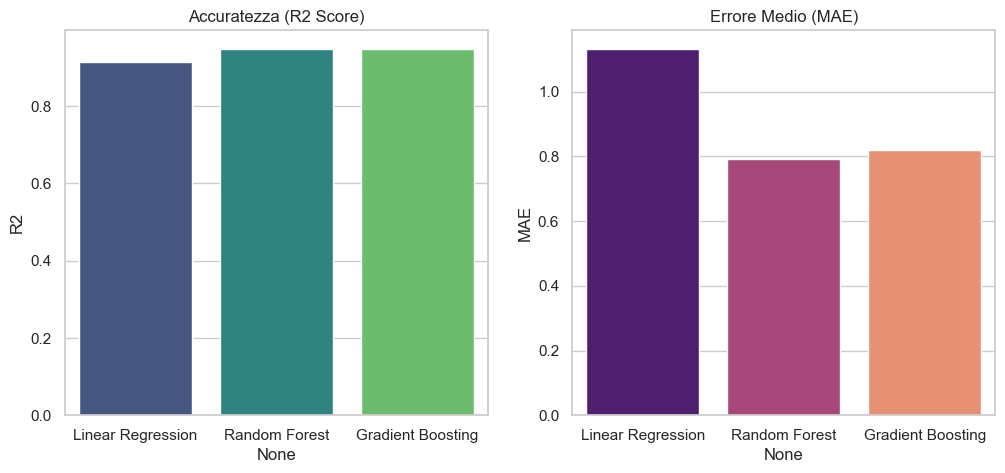

In [30]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=res_df.index, y=res_df['R2'], palette="viridis")
plt.title('Accuratezza (R2 Score)')

plt.subplot(1, 2, 2)
sns.barplot(x=res_df.index, y=res_df['MAE'], palette="magma")
plt.title('Errore Medio (MAE)')
plt.show()


## 4. Analisi Chirurgica: Random Forest
Approfondiamo il funzionamento del Random Forest (modello scelto per stabilità e interpretabilità).

### 4.1 Learning Curve (Curva di Apprendimento)
**Cosa mostra:** Come cambia l'errore del modello man mano che forniamo più dati di addestramento.
**Come leggerlo:**
* **Asse X:** Numero di mostri usati per il training.
* **Linee:** La linea rossa è l'errore sul Training, la verde sulla Validazione.
* **Interpretazione:** Se le linee convergono (si avvicinano) verso un errore basso, il modello è buono. Se rimangono distanti, c'è Overfitting (il modello impara a memoria). Se convergono ma l'errore è alto, c'è Underfitting.


⏳ Calcolo Learning Curve per Random Forest...


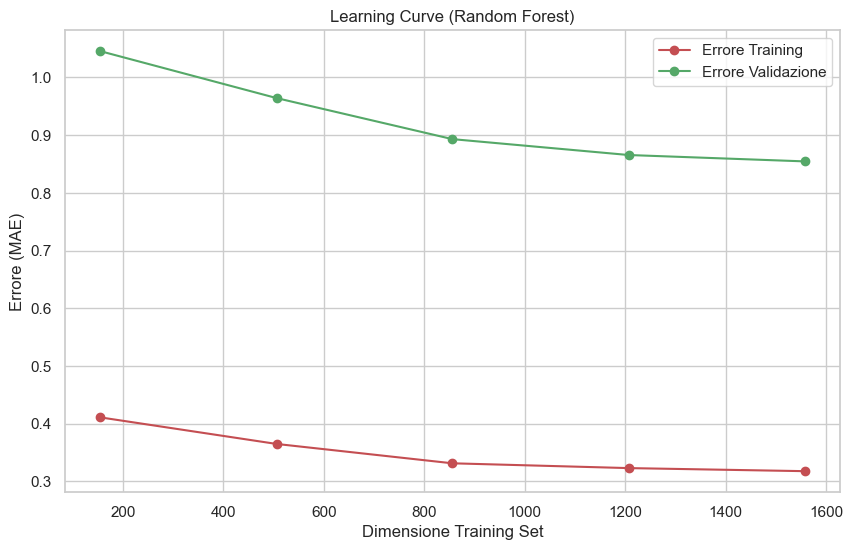

In [31]:
print("⏳ Calcolo Learning Curve per Random Forest...")
# Usiamo n_jobs=1 qui per evitare i warning infiniti del tuo ambiente
train_sizes, train_scores, test_scores = learning_curve(
    models["Random Forest"], X_train, y_train, cv=5, n_jobs=1, 
    train_sizes=np.linspace(0.1, 1.0, 5), scoring="neg_mean_absolute_error"
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, -np.mean(train_scores, axis=1), 'o-', color="r", label="Errore Training")
plt.plot(train_sizes, -np.mean(test_scores, axis=1), 'o-', color="g", label="Errore Validazione")
plt.title("Learning Curve (Random Forest)")
plt.xlabel("Dimensione Training Set")
plt.ylabel("Errore (MAE)")
plt.legend()
plt.show()


### 4.2 Analisi di Convergenza (Error vs N_Estimators)
**Cosa mostra:** Quanti alberi servono nella foresta prima che il modello smetta di migliorare.
**Come leggerlo:**
* **Asse X:** Numero di alberi (da 1 a 100).
* **Asse Y:** Errore Quadratico Medio (MSE). Più basso è meglio.
* **Interpretazione:** All'inizio l'errore crolla verticalmente (ogni albero aggiunto aiuta molto). Cerca il punto in cui la linea diventa piatta ("Plateau"). Quello è il numero ottimale di alberi; aggiungerne altri spreca solo calcoli senza migliorare la precisione.


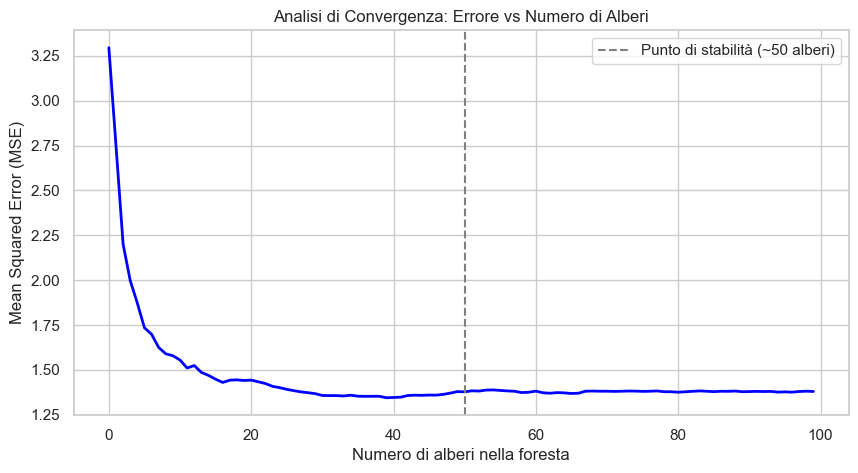

In [32]:
# Estraiamo le predizioni individuali di ogni albero della foresta
all_trees = models["Random Forest"].estimators_
tree_preds = np.array([tree.predict(X_test.values) for tree in all_trees])

# Calcolo MSE cumulativo
cum_preds = np.cumsum(tree_preds, axis=0) / np.arange(1, len(all_trees) + 1)[:, None]
cum_mse = [mean_squared_error(y_test, p) for p in cum_preds]

plt.figure(figsize=(10, 5))
plt.plot(cum_mse, color='blue', lw=2)
plt.title("Analisi di Convergenza: Errore vs Numero di Alberi")
plt.xlabel("Numero di alberi nella foresta")
plt.ylabel("Mean Squared Error (MSE)")
plt.axvline(x=50, color='gray', linestyle='--', label='Punto di stabilità (~50 alberi)')
plt.legend()
plt.show()


### 4.3 Analisi dell'Incertezza
**Cosa mostra:** Quanto il modello è "sicuro" delle sue predizioni su un campione di 20 mostri.
**Come leggerlo:**
* **Punti Blu:** La predizione media del modello.
* **X Rosse:** Il valore reale (Target) del mostro.
* **Barre Grigie:** Rappresentano il disaccordo tra gli alberi della foresta.
* **Interpretazione:**
    * **Barra Corta:** Tutti gli alberi sono d'accordo -> Alta Confidenza.
    * **Barra Lunga:** Gli alberi danno risposte diverse -> Bassa Confidenza (Mostro anomalo o difficile).


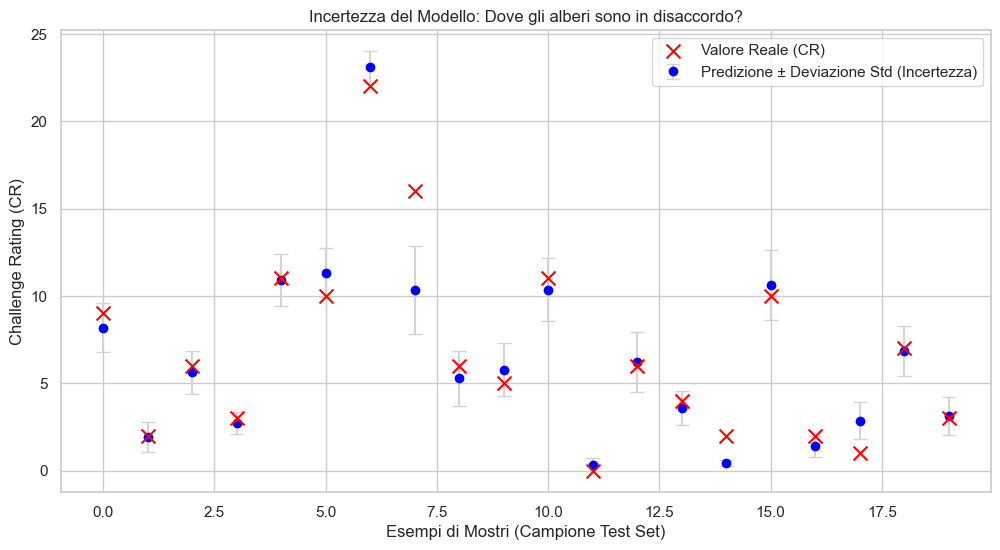

In [33]:
sample_idx = np.random.choice(len(X_test), 20, replace=False)
X_sample = X_test.iloc[sample_idx]
y_sample = y_test.iloc[sample_idx].values

# Raccogliamo i voti di tutti gli alberi
votes = np.array([tree.predict(X_sample.values) for tree in all_trees])
stds = np.std(votes, axis=0)
means = np.mean(votes, axis=0)

plt.figure(figsize=(12, 6))
plt.errorbar(range(20), means, yerr=stds, fmt='o', color='blue', ecolor='lightgray', capsize=5, label='Predizione ± Deviazione Std (Incertezza)')
plt.scatter(range(20), y_sample, color='red', marker='x', s=100, label='Valore Reale (CR)', zorder=5)
plt.title("Incertezza del Modello: Dove gli alberi sono in disaccordo?")
plt.xlabel("Esempi di Mostri (Campione Test Set)")
plt.ylabel("Challenge Rating (CR)")
plt.legend()
plt.show()


### 4.4 Feature Importance Cumulativa
**Cosa mostra:** Quante statistiche (feature) sono realmente necessarie per spiegare il CR.
**Come leggerlo:**
* **Asse X:** Numero di feature usate (ordinate dalla più potente alla meno potente).
* **Asse Y:** Percentuale di importanza cumulativa (da 0 a 1.0).
* **Interpretazione:** La curva sale rapidamente. Il punto in cui attraversa la linea rossa (95%) ci dice che possiamo buttare via tutte le feature successive senza perdere precisione. Conferma che il CR dipende da pochi fattori chiave (HP, AC, Danni).


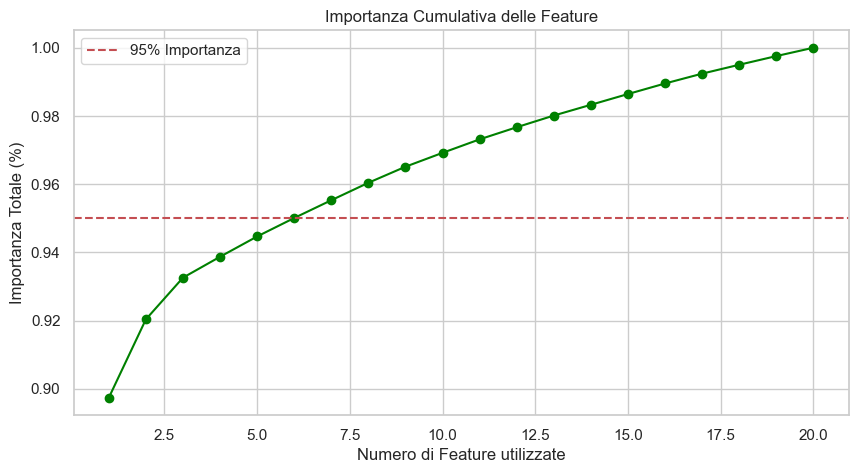

💡 Il 95% del CR è spiegato dalle prime 6 feature.


In [34]:
importances = models["Random Forest"].feature_importances_
indices = np.argsort(importances)[::-1]
cum_importance = np.cumsum(importances[indices])

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(importances) + 1), cum_importance, color='green', marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Importanza')
plt.title("Importanza Cumulativa delle Feature")
plt.xlabel("Numero di Feature utilizzate")
plt.ylabel("Importanza Totale (%)")
plt.legend()
plt.show()

print(f"💡 Il 95% del CR è spiegato dalle prime {np.where(cum_importance > 0.95)[0][0] + 1} feature.")


### 4.5 Esemplificazione: Visualizzazione di un Albero
**Cosa mostra:** La logica decisionale "If-Then-Else" di un singolo albero estratto dalla foresta.
**Come leggerlo:**
* È un diagramma di flusso. Si parte dall'alto (Root Node).
* Ogni casella pone una domanda (es. `hit_points <= 150?`). Se VERO vai a sinistra, se FALSO a destra.
* Scendendo si arriva alle foglie finali che contengono il valore predetto (`value`). Questo grafico rende il modello "White Box" (spiegabile).


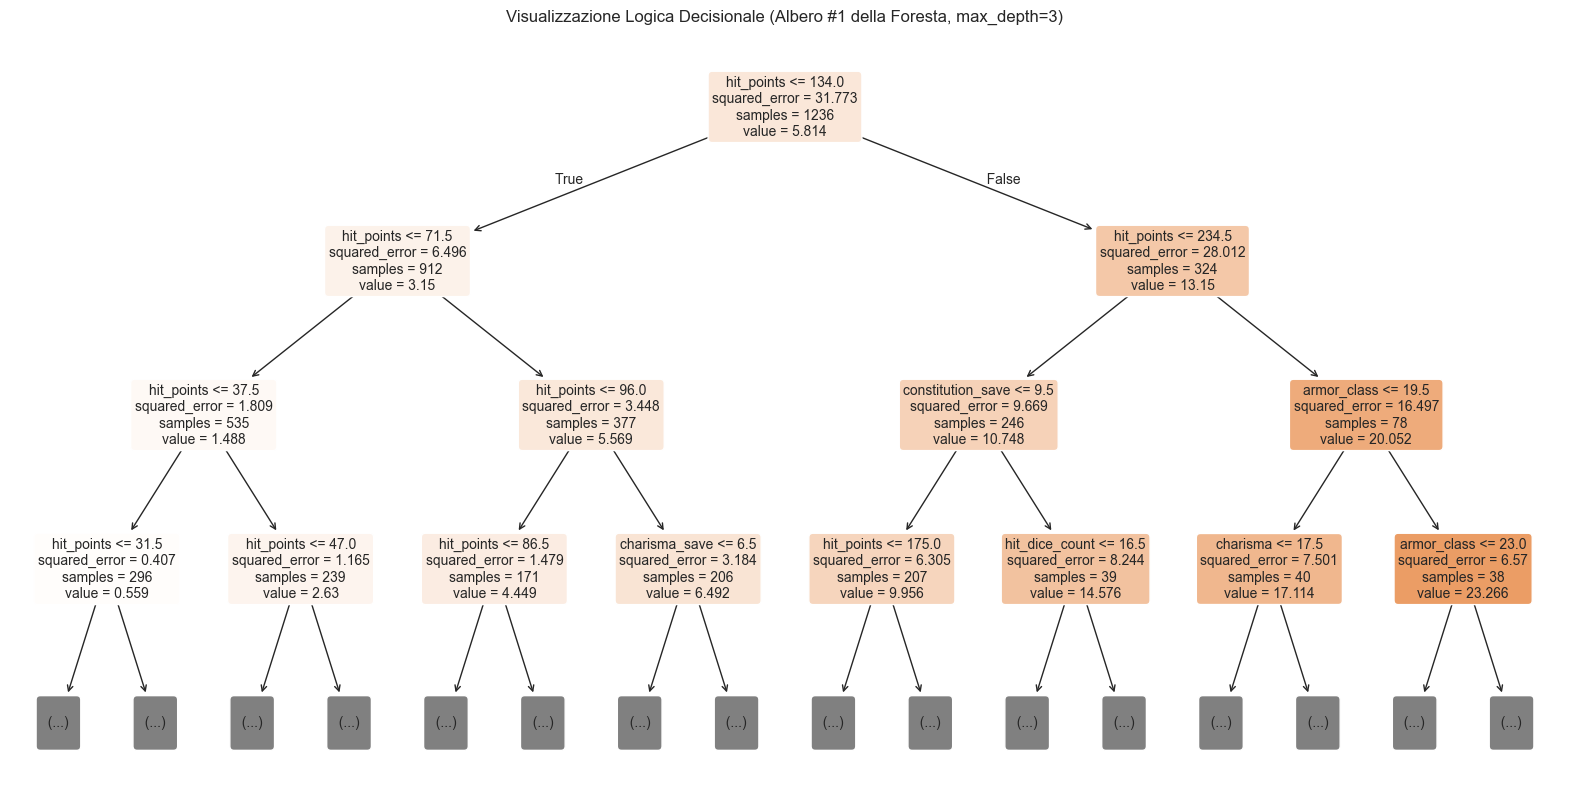

In [35]:
plt.figure(figsize=(20, 10))
plot_tree(all_trees[0], feature_names=X.columns, max_depth=3, filled=True, rounded=True, fontsize=10)
plt.title("Visualizzazione Logica Decisionale (Albero #1 della Foresta, max_depth=3)")
plt.show()


## 5. Analisi degli Errori (Residual Analysis)
Verifichiamo scientificamente *dove* e *come* il modello sbaglia.

### Grafico 1: Predetto vs Reale (Scatter Plot)
* **Obiettivo:** Verificare l'accuratezza puntuale.
* **Come leggerlo:** Ogni punto blu è un mostro. La linea rossa tratteggiata è la perfezione.
* **Interpretazione:** Se i punti stanno sulla linea rossa, la predizione è perfetta. Punti molto sopra la linea = Sovrastima. Punti molto sotto = Sottostima.

### Grafico 2: Distribuzione dei Residui (Istogramma)
* **Obiettivo:** Verificare la presenza di Bias sistematici.
* **Come leggerlo:** Mostra la frequenza degli errori (Errore = Reale - Predetto).
* **Interpretazione:** Deve formare una "Campana" (Gaussiana) alta e stretta centrata sullo 0.
    * Se è centrata su 0: Il modello è onesto (non "bara" sovrastimando sempre).
    * Se è larga: Il modello è impreciso.
    * Se è spostata a destra/sinistra: Il modello ha un Bias.


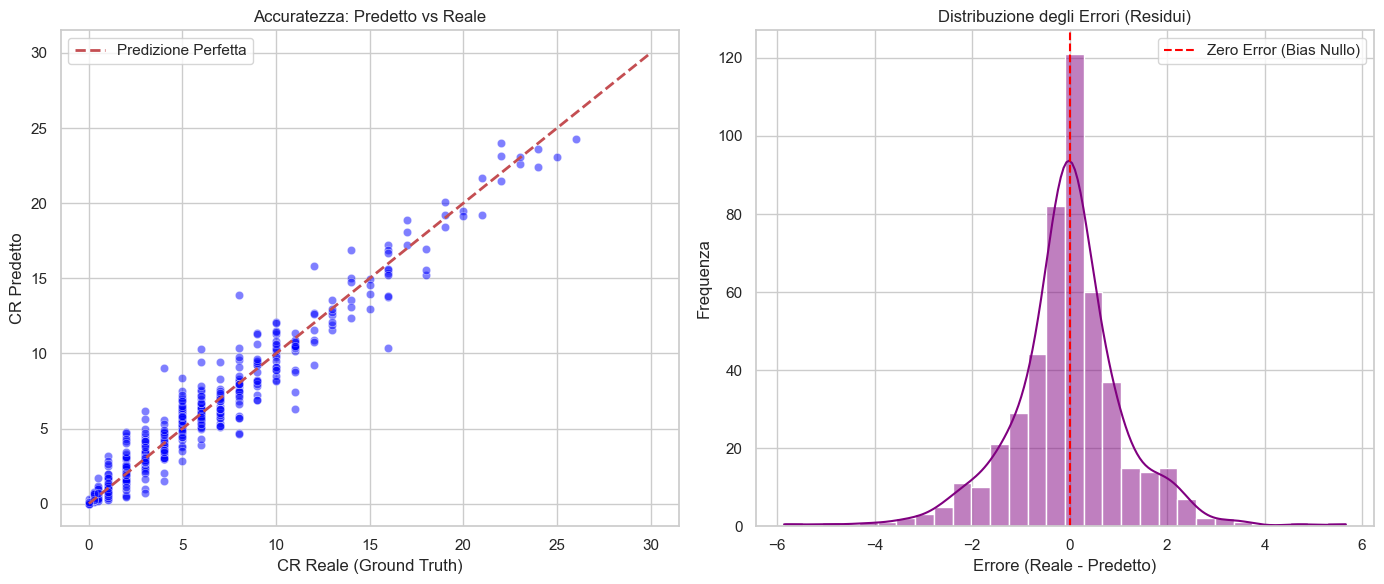

In [36]:
# Calcolo dei residui
residuals = y_test - predictions["Random Forest"]

plt.figure(figsize=(14, 6))

# --- GRAFICO 1: Predetto vs Reale ---
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=predictions["Random Forest"], alpha=0.5, color='blue')
# Linea diagonale perfetta
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', linewidth=2, label='Predizione Perfetta')
plt.title('Accuratezza: Predetto vs Reale')
plt.xlabel('CR Reale (Ground Truth)')
plt.ylabel('CR Predetto')
plt.legend()

# --- GRAFICO 2: Distribuzione Residui ---
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.axvline(0, color='red', linestyle='--', label='Zero Error (Bias Nullo)')
plt.title('Distribuzione degli Errori (Residui)')
plt.xlabel('Errore (Reale - Predetto)')
plt.ylabel('Frequenza')
plt.legend()

plt.tight_layout()
plt.show()


In [37]:
# Creiamo un DataFrame con i nomi e l'importanza
feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': models["Random Forest"].feature_importances_
}).sort_values(by='Importance', ascending=False)

print("🏆 CLASSIFICA DELLE FEATURE PIÙ IMPORTANTI:")
print(feat_importance.head(20).to_string(index=False))

🏆 CLASSIFICA DELLE FEATURE PIÙ IMPORTANTI:
                   Feature  Importance
                hit_points    0.897362
               armor_class    0.022993
               wisdom_save    0.012216
         intelligence_save    0.006138
         constitution_save    0.005948
   damage_immunities_count    0.005417
  damage_resistances_count    0.005213
                  charisma    0.005118
   legendary_actions_count    0.004707
        passive_perception    0.004071
             charisma_save    0.003957
                  strength    0.003553
            hit_dice_count    0.003425
condition_immunities_count    0.003155
   special_abilities_count    0.003155
              constitution    0.003092
            dexterity_save    0.002885
                 dexterity    0.002607
             actions_count    0.002541
            skills.stealth    0.002447
